### Inference Analysis

In [1]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import itertools
import math
import einops as E

In [2]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the current directory:")
for item in contents:
    print(item)


Current directory: C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\universeg
Contents of the current directory:
.ipynb_checkpoints
inference_analysis.ipynb
model.py
nn
training.py
validation.py
__init__.py
__pycache__


In [3]:
# !git clone https://github.com/JJGO/UniverSeg
# !python -m pip install -r ./UniverSeg/requirements.txt
# # Add package directory to path
#!pip install torch


import torch
from model import universeg

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Instantiate the model and move it to the device
model = universeg(pretrained=True)
model.to(device)



UniverSeg(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_blocks): ModuleList(
    (0): CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
      (support): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1-3): 3 x CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_si

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device('cuda')
    model.to(device)
    print("Model moved to CUDA (GPU)")
else:
    print("CUDA is not available. Model remains on CPU.")


CUDA is not available. Model remains on CPU.


In [5]:
torch.cuda.get_arch_list()

[]

In [6]:
# def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
#     M = len(tensors)
#     N = len(next(iter(tensors.values())))
# 
#     cols = col_wrap
#     rows = math.ceil(N/cols) * M
# 
#     d = 2.5
#     fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
#     if rows == 1:
#       axes = axes.reshape(1, cols)
# 
#     for g, (grp, tensors) in enumerate(tensors.items()):
#         for k, tensor in enumerate(tensors):
#             col = k % cols
#             row = g + M*(k//cols)
#             x = tensor.detach().cpu().numpy().squeeze()
#             ax = axes[row,col]
#             if len(x.shape) == 2:
#                 ax.imshow(x,vmin=0, vmax=1, cmap='gray')
#             else:
#                 ax.imshow(E.rearrange(x,'C H W -> H W C'))
#             if col == 0:
#                 ax.set_ylabel(grp, fontsize=16)
#             if col_names is not None and row == 0:
#                 ax.set_title(col_names[col])
# 
#     for i in range(rows):
#         for j in range(cols):
#             ax = axes[i,j]
#             ax.grid(False)
#             ax.set_xticks([])
#             ax.set_yticks([])
# 
#     if title:
#         plt.suptitle(title, fontsize=20)
# 
#     plt.tight_layout()

### Inference using papillary masks

In [21]:
import os
import cv2
#from torch.utils.data import Dataset
from torchvision import transforms

import os
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, input_folder, output_folder, transform=None):
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.input_files = sorted(os.listdir(input_folder))
        self.output_files = sorted(os.listdir(output_folder))
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_img_path = os.path.join(self.input_folder, self.input_files[idx])
        output_img_path = os.path.join(self.output_folder, self.output_files[idx])

        # Read images in grayscale
        input_img = cv2.imread(input_img_path, cv2.IMREAD_GRAYSCALE)
        output_img = cv2.imread(output_img_path, cv2.IMREAD_GRAYSCALE)

        # Apply transformations
        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        # Convert images to PyTorch tensors
        input_img = torch.tensor(input_img, dtype=torch.float32)
        output_img = torch.tensor(output_img, dtype=torch.float32)

        return input_img, output_img

# Define folders
# Define folders with double backslashes
support_input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\\train_input_png"
support_output_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\\train_nonpapoutput_png"

test_input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\testinput"
test_output_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\test_nonpap_output_png"

# Create datasets
d_support = CustomDataset(support_input_folder, support_output_folder)
d_test = CustomDataset(test_input_folder, test_input_folder)

#display ( d_support, d_test )
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Example usage
# n_support = 48
# support_loader = torch.utils.data.DataLoader(support_dataset, batch_size=n_support, shuffle=True)
# for batch_idx, (support_images, support_labels) in enumerate(support_loader):
#     support_images = support_images.to(device)
#     support_labels = support_labels.to(device)



In [8]:
# import os
# import cv2
# import numpy as np
# import pandas as pd
# import scipy.io as sio
# import torch
# from torch.utils.data import Dataset
# from typing import Literal, Optional
# 
# class CustomDataset(Dataset):
#     def __init__(self, dataset: Literal["train", "test"]):
#         self.dataset = dataset
#         self.image_folder = None
#         self.mask_folder = None
#         self.df = None
#         if dataset == "train":
#             self.image_folder = "Training/train_input_png"
#             self.mask_folder = "Training/train_nonpapoutput_png"
#             self.df = pd.read_csv("Training_Output.csv")
#         elif dataset == "test":
#             self.image_folder = "testinput"
#             self.mask_folder = "test_nonpap_output_png"
#             self.df = pd.read_csv("Testing_Input.csv")
# 
#     def __len__(self):
#         return len(self.df)
# 
#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_folder, self.df.iloc[idx]['Processed_Image_File'])
#         mask_path = os.path.join(self.mask_folder, self.df.iloc[idx]['Training_Output_Mask'])
# 
#         # Load image
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
#         image = np.expand_dims(image, axis=0)  # Add channel dimension
# 
#         # Load mask
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
#         mask = np.expand_dims(mask, axis=0)  # Add channel dimension
# 
#         return torch.from_numpy(image), torch.from_numpy(mask)


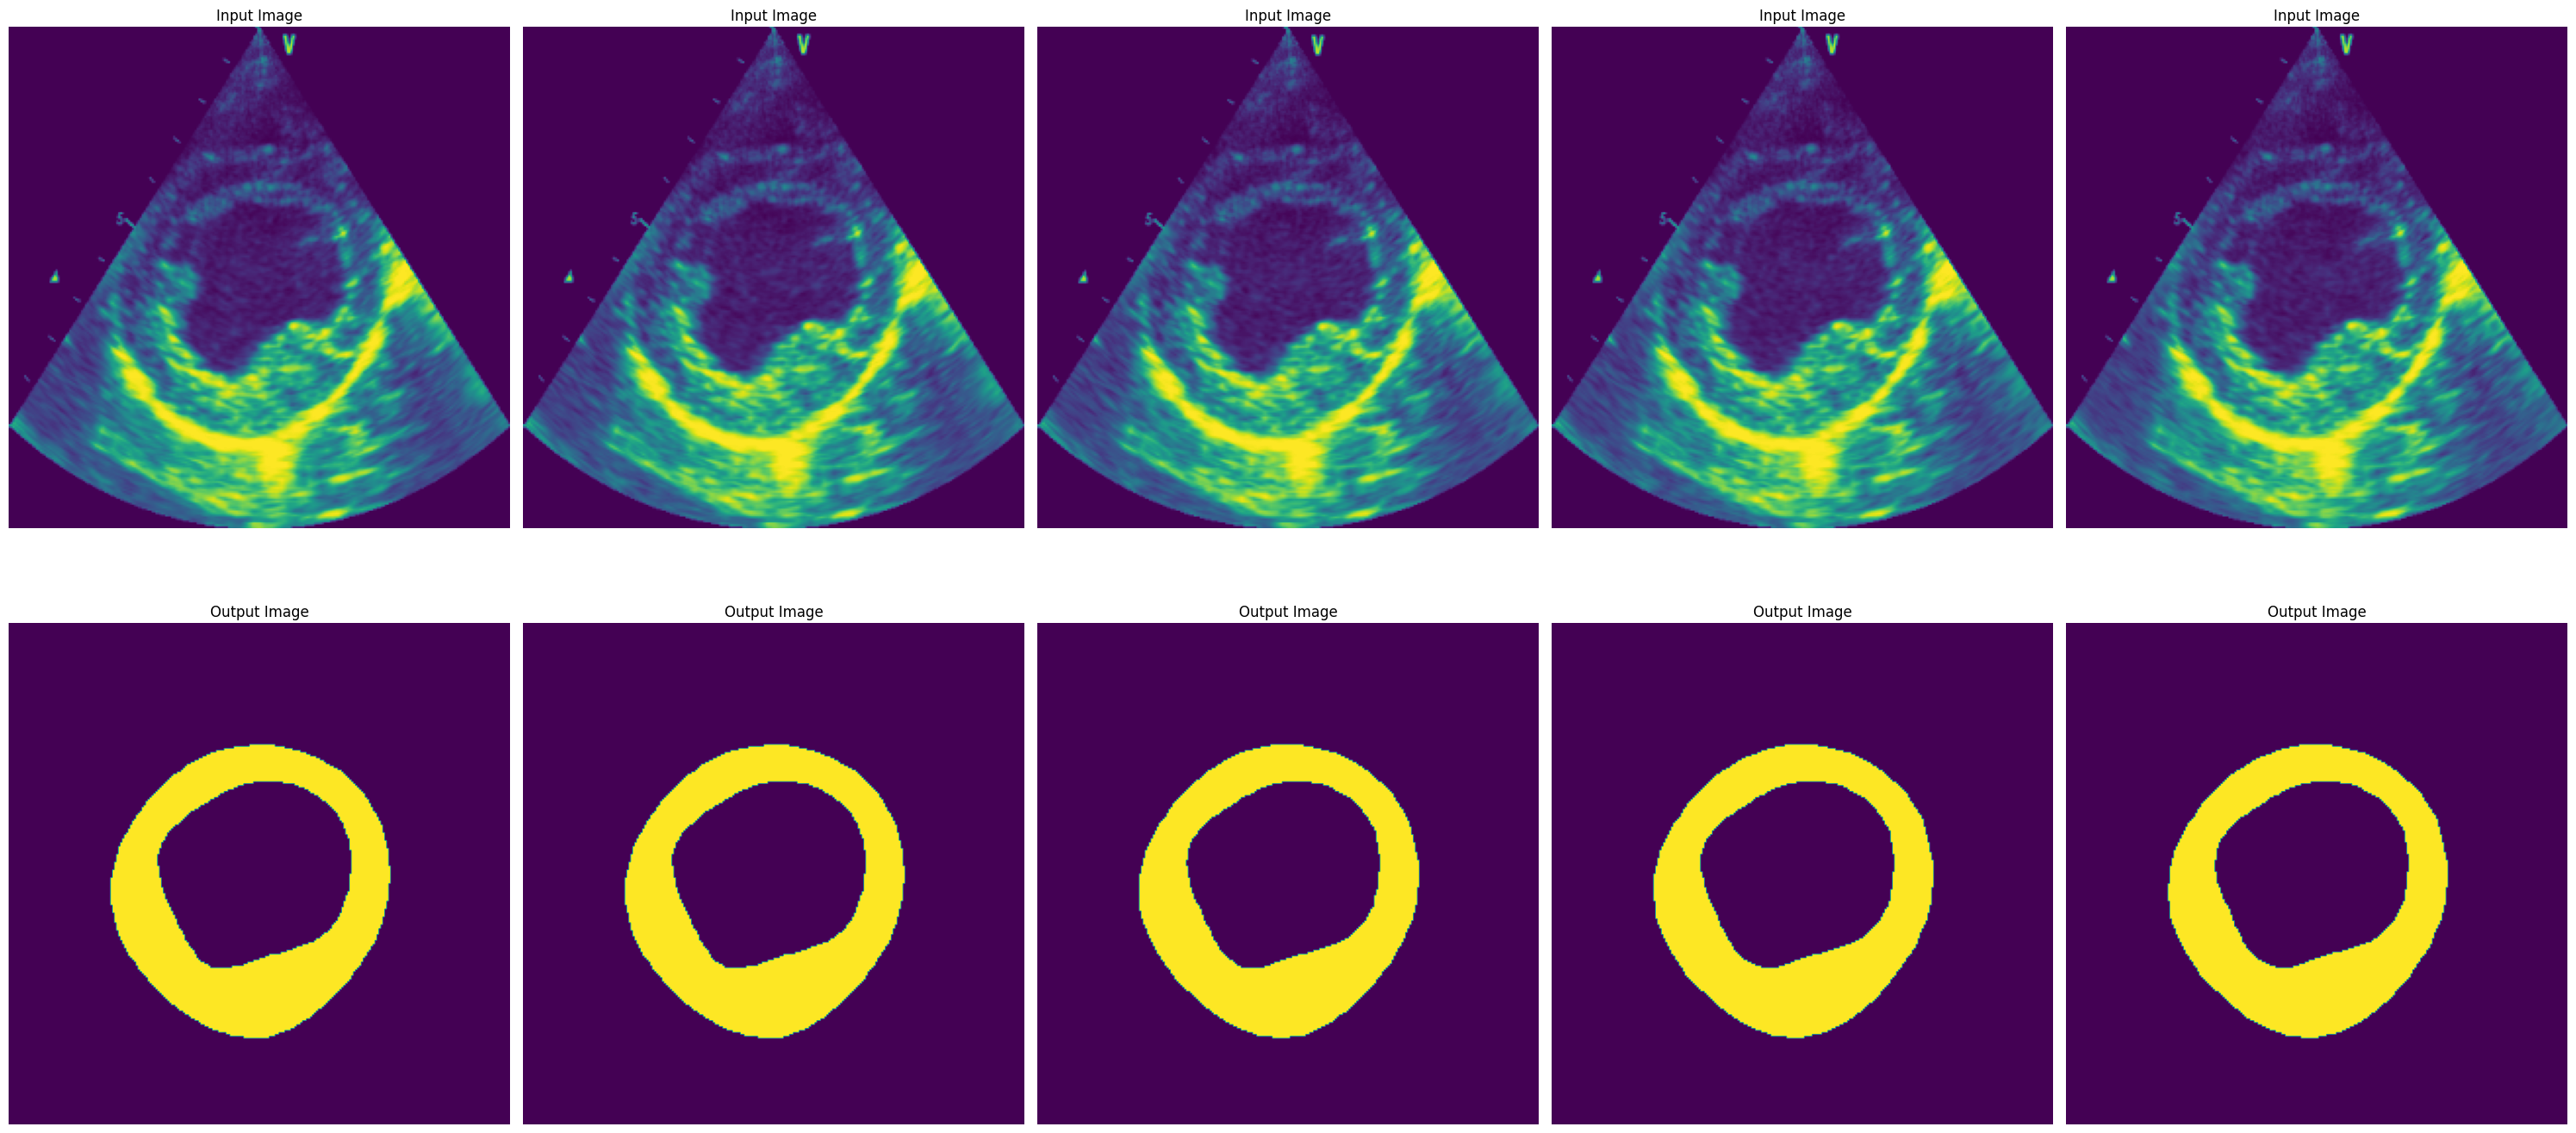

In [9]:
import matplotlib.pyplot as plt

# Display images from the support dataset
num_images_to_display = 5
fig, axes = plt.subplots(2, num_images_to_display, figsize=(30, 15))  # Adjust the figsize to make the figure larger

for i in range(num_images_to_display):
    input_img, output_img = d_support[i]  # Get input and output images from the dataset
    axes[0, i].imshow(input_img)
    axes[0, i].set_title("Input Image")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(output_img)
    axes[1, i].set_title("Output Image")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


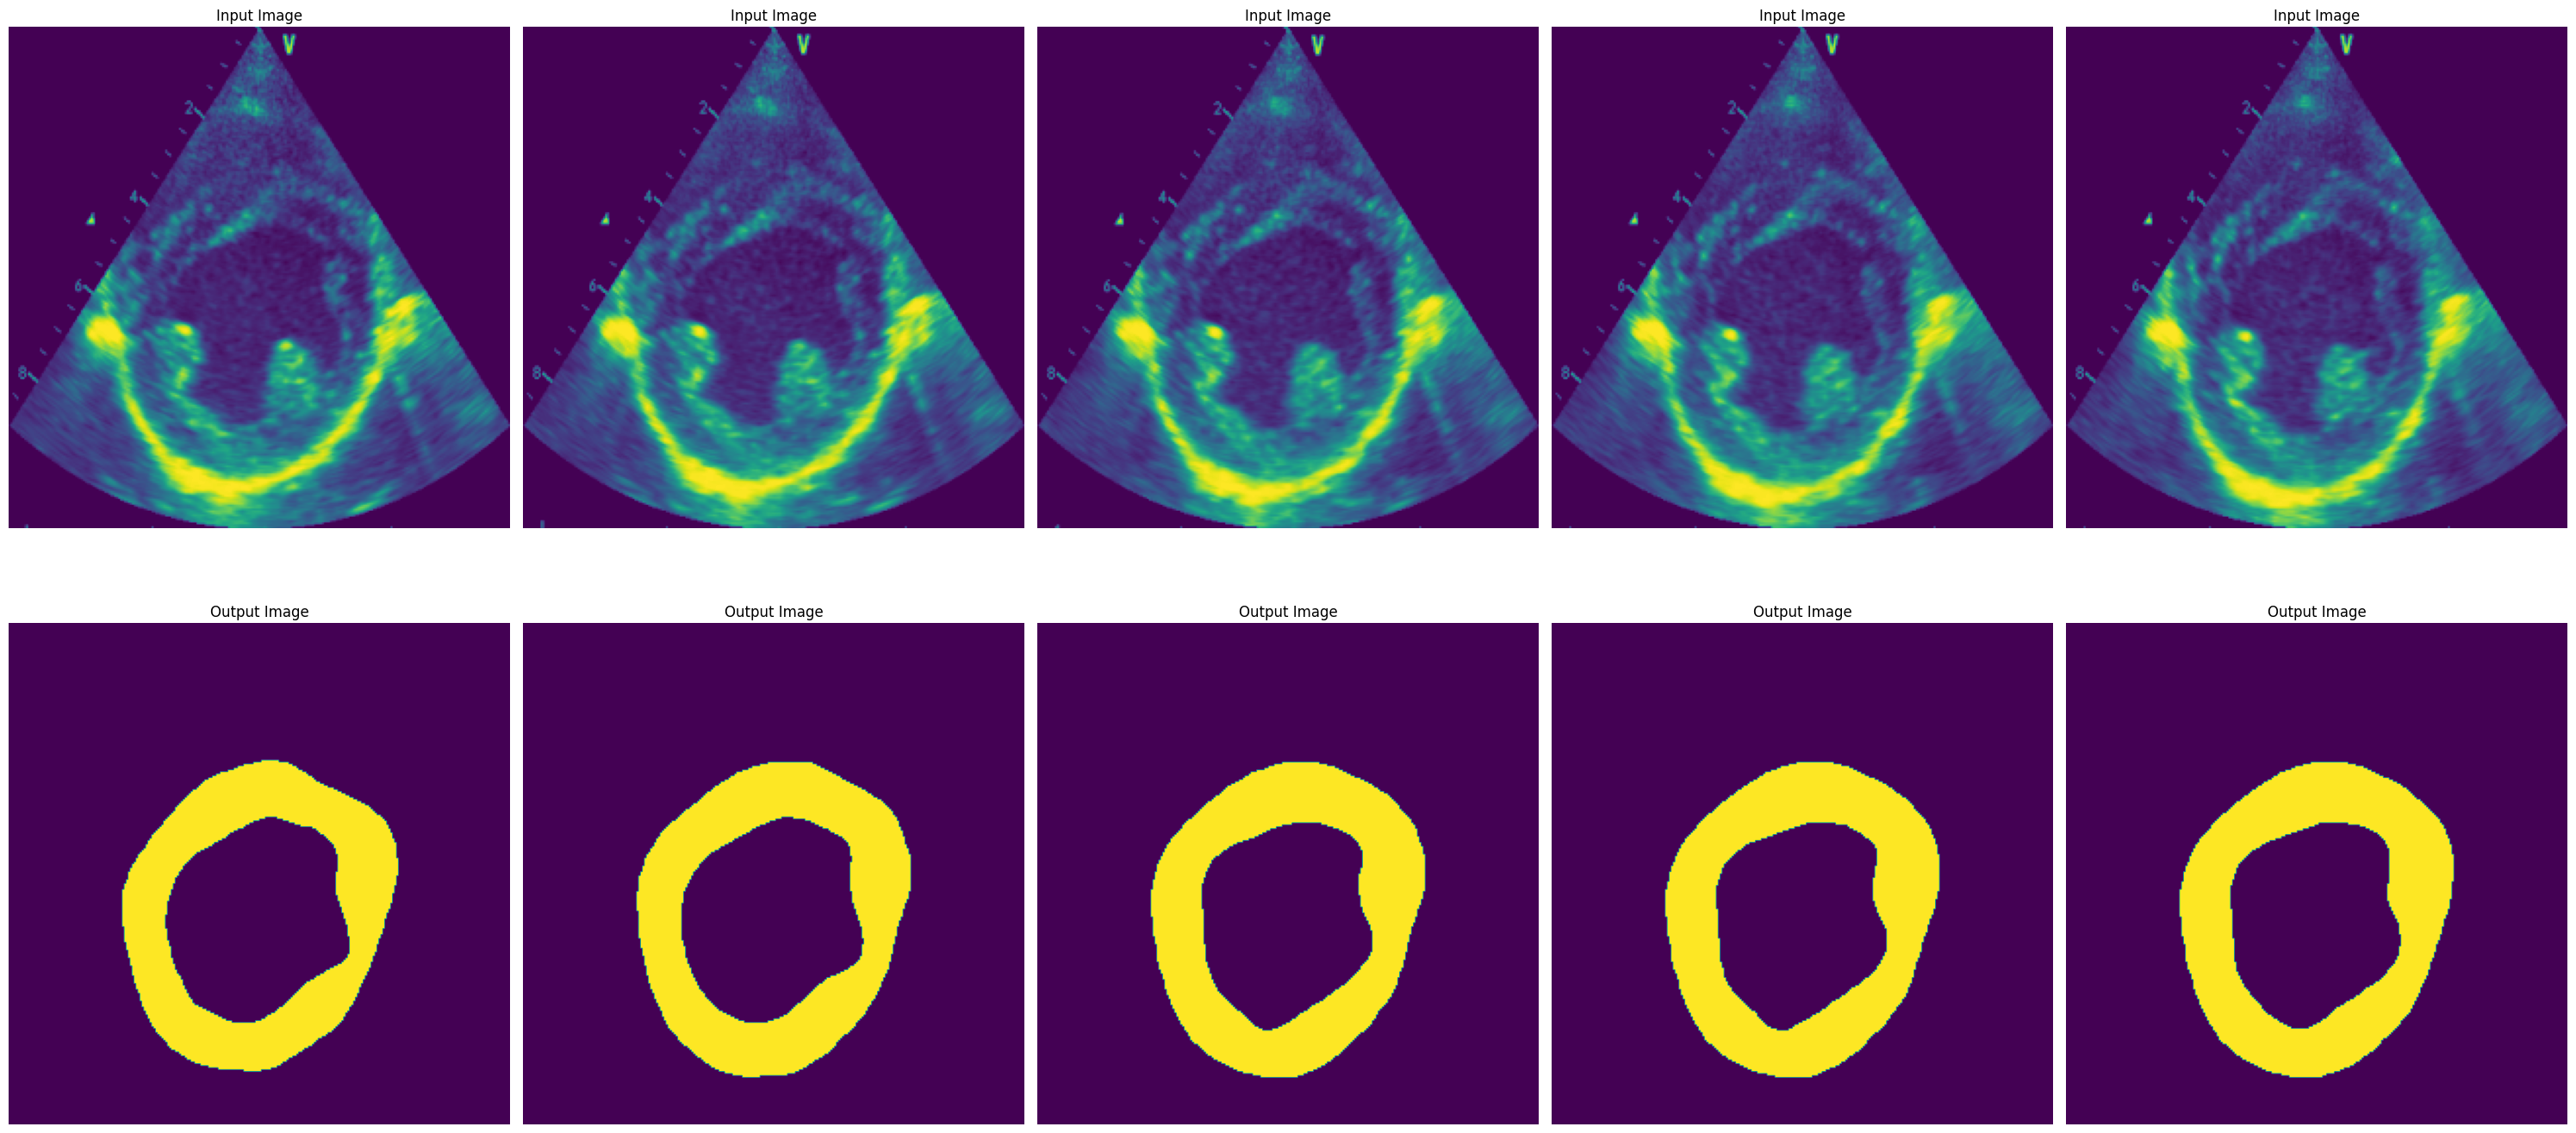

In [10]:
import matplotlib.pyplot as plt

# Display images from the test dataset
num_images_to_display = 5
fig, axes = plt.subplots(2, num_images_to_display, figsize=(30, 15))  # Adjust the figsize to make the figure larger

for i in range(num_images_to_display):
    input_img, output_img = d_test[i]  # Get input and output images from the dataset
    axes[0, i].imshow(input_img)
    axes[0, i].set_title("Input Image")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(output_img)
    axes[1, i].set_title("Output Image")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


### Inference on unseen task using Universeg

In [11]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [12]:
n_support = 48
support_loader = torch.utils.data.DataLoader(d_support, batch_size=n_support, shuffle=True)
# print("Number of input files:", len(d_support.input_files))
# print("Number of output files:", len(d_support.output_files))

for batch_idx, (support_images, support_labels) in enumerate(support_loader):
    support_images = support_images.to(device)

In [13]:
#     support_labels = support_labels.to(device)

d_support = CustomDataset(support_input_folder, support_output_folder)
d_test = CustomDataset(test_input_folder, test_output_folder)

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))


# Convert list of NumPy arrays to a single NumPy array
support_images_np = np.array(support_images)
support_labels_np = np.array(support_labels)

# Convert NumPy arrays to tensors and detach from computation graph
support_images = torch.tensor(support_images_np, device=device).detach()
support_labels = torch.tensor(support_labels_np, device=device).detach()




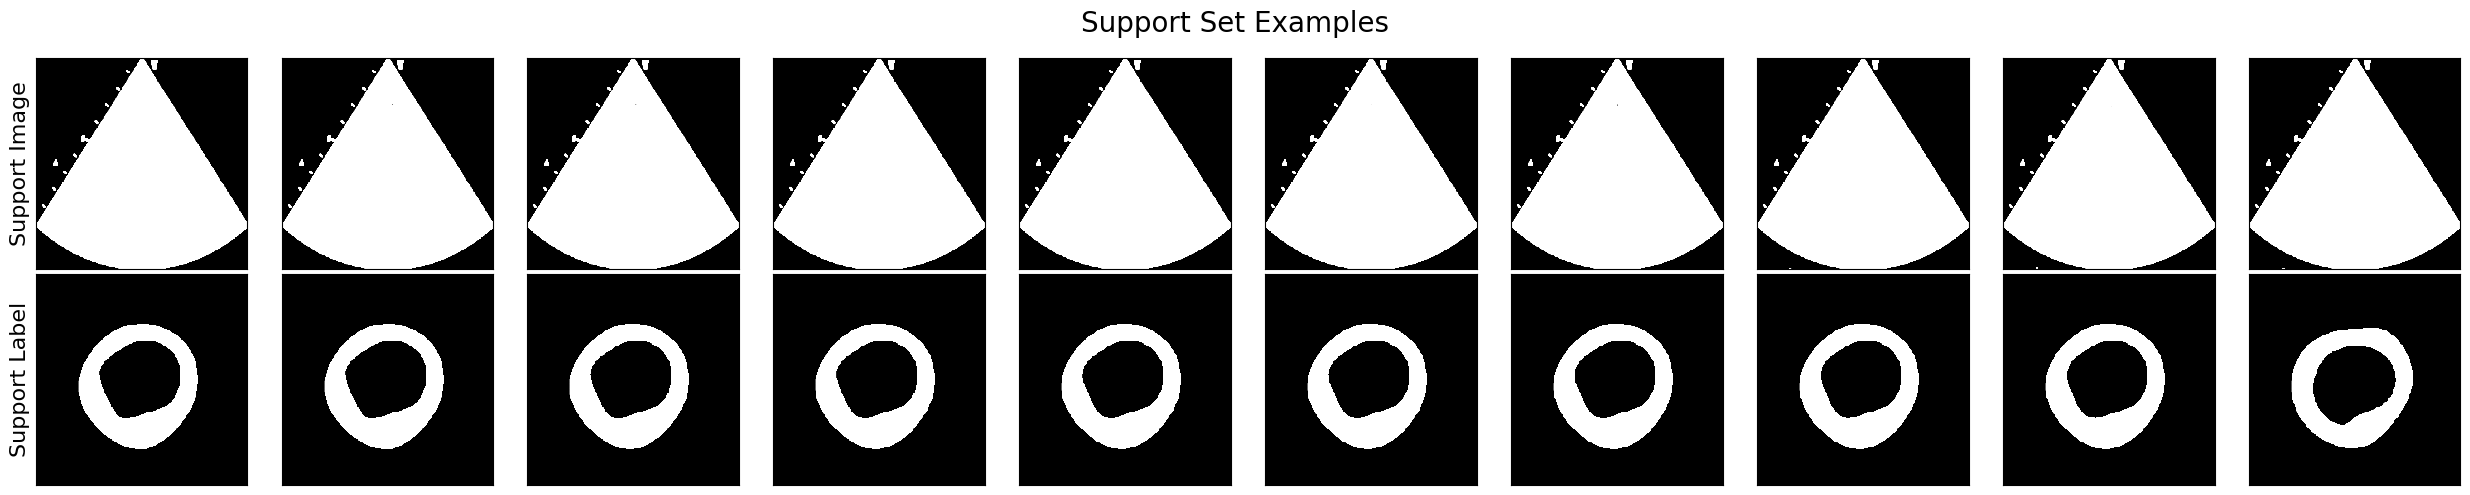

In [22]:
import math
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples', figsize=(20, 20))

Let's perform inference on a test entry and visualize the prediction

In [28]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
#image = image.unsqueeze(0) 
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# # visualize
# res = {'data': [image, label, pred, pred > 0.5]}
# titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
# visualize_tensors(res, col_wrap=4, col_names=titles)

EinopsError:  Error while processing rearrange-reduction pattern "B 1 H W -> B 1 1 H W".
 Input tensor shape: torch.Size([1, 256, 256]). Additional info: {}.
 Wrong shape: expected 4 dims. Received 3-dim tensor.

### Inference Analysis


In [18]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [19]:
from collections import defaultdict
n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

  0%|          | 0/10 [00:00<?, ?it/s]


EinopsError:  Error while processing rearrange-reduction pattern "B 1 H W -> B 1 1 H W".
 Input tensor shape: torch.Size([1, 256, 256]). Additional info: {}.
 Wrong shape: expected 4 dims. Received 3-dim tensor.

### Effect of the Support Set Size

In [20]:
# d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)



EinopsError:  Error while processing rearrange-reduction pattern "B 1 H W -> B 1 1 H W".
 Input tensor shape: torch.Size([1, 256, 256]). Additional info: {}.
 Wrong shape: expected 4 dims. Received 3-dim tensor.

In [ ]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))